# The $z$-transform

This notebook shows some techniques for dealing with discrete systems analytically using the $z$ transform

In [1]:
import sympy
sympy.init_printing()

In [2]:
s, z, q = sympy.symbols('s, z, q')
k = sympy.Symbol('k', integer=True)
Dt = sympy.Symbol('\Delta t', positive=True)

The $z$ transform of a sampled signal ($y^*(t)$) can be written as

$$\mathcal{Z}[y^*(t)] = \sum_{k=0}^{\infty} f(k \Delta t) z^{-k}$$

For a unit step, $f(t)=1$ and we can obtain the $z$ transform as an infinte series as follows:

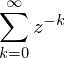

In [32]:
unitstep = sympy.Sum(1/z**k, (k, 0, sympy.oo))
unitstep

Sympy can recognise this infinite series as a geometric series, and under certain conditions for convergence, it can find a finite representation:

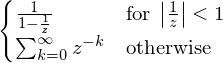

In [33]:
shortform = unitstep.doit()
shortform

To extract the first case solution, we use `args`:

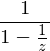

In [35]:
uz = shortform.args[0][0]
uz

For a first order difference equation (the discrete equivalent of a first order differential equation):

$$ y(k) + a_1 y(k - 1) = b_1 u(k - 1) $$

We can write this as 

$$ Y(z) + a_1 z^{-1} Y(z) = b_1 z^{-1} U(z) $$

Leading to a discrete transfer function:

In [37]:
a1, b1 = sympy.symbols('a1, b1')

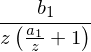

In [38]:
Gz = b1*z**-1/(1 + a1*z**-1)
Gz

Since I have not found an easy way to get sympy to report negative powers of $z$, I find it convenient to define

$$q = z^{-1}$$

In [39]:
def qsubs(fz):
    return fz.subs({z: q**-1})

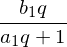

In [40]:
qsubs(Gz)

To find the response of this system to the unit input, we can multiply the input and the transfer function. Note that this is equivalent to convolution of the polinomial coefficients.

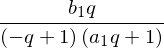

In [41]:
yz = Gz*uz
qsubs(yz)

In [54]:
K = 2 # The worked version in the textbook uses 2 even though the text says 20
tau = 1

In [55]:
Dt = 1

In [56]:
parameters = {a1: -sympy.exp(-Dt/tau),
              b1: K*(1 -  sympy.exp(-Dt/tau))
             }
stepresponse = yz.subs(parameters)

To obtain the values of the response at the sampling points, we need to expand the polynomial. We can do this using Taylor series. Sympy has a `Poly` class which can extract all the coefficients of the polynomial easily.

In [57]:
N = 10

In [58]:
qpoly = sympy.Poly(qsubs(stepresponse).series(q, 0, N).removeO(), q)
qpoly

In [59]:
qpoly.all_coeffs()

Notice that the coefficients are returned in decreasing orders of $q$, but we want then in increasing orders to plot them.

In [60]:
responses = list(reversed(qpoly.all_coeffs()))

In [61]:
import matplotlib.pyplot as plt
import numpy

In [62]:
%matplotlib inline

Let's compare this with the step response of a continuous first order system with the same parameters:

In [63]:
sampledt = Dt*numpy.arange(N)

In [64]:
smootht = numpy.linspace(0, Dt*N)

In [65]:
analytic_firstorder = K*(1 - numpy.exp(-smootht/tau))

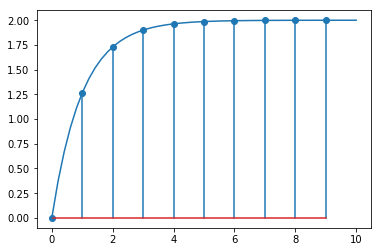

In [68]:
plt.stem(sampledt, responses)
plt.plot(smootht, analytic_firstorder)

We can get the same values without going through the symbolic steps by using the `scipy.signal` library.

In [69]:
import scipy.signal

In [70]:
a1 = -numpy.exp(-Dt/tau)
b1 = K*(1 - numpy.exp(-Dt/tau))

In [71]:
scipy.signal.dlti?

Note this uses the transfer function in terms of $z$ (not $z^{-1}$).

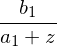

In [72]:
Gz.expand()

In [73]:
scipy.signal.dlti?

In [75]:
Gdiscrete = scipy.signal.dlti(b1, [1, a1], dt=1)

In [76]:
_, response = Gdiscrete.step(n=N)

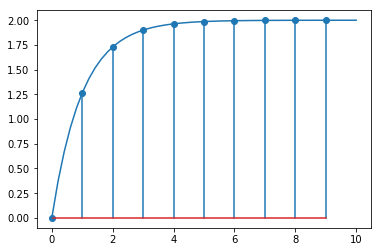

In [77]:
plt.stem(sampledt, numpy.squeeze(response))
plt.plot(smootht, analytic_firstorder)